In [1]:

import sounddevice as sd
import numpy as np
import matplotlib.pyplot as plt
from tkinter import *
from tkinter import ttk
import time
from copy import deepcopy
import mido


from synt.function import *
from synt.const import *
from synt.synt import *
from synt.osc import *

from synt.envolv import *
from synt.effects import *
from synt.instrumento import *
from synt.mixer import *
from synt.midisequencer import *
from synt.filter import *

import os
import librosa

In [2]:
'''MOSTAR ONDAS COPIANDOLAS PARA QUE NO SE ALTERE EL FRAME'''
from copy import deepcopy
def showOsc(osc, time, chunks=False):
    _osc = deepcopy(osc)
    signal = np.zeros(0)
    _chunks = int(time*(SRATE+CHUNK)/CHUNK)
    if chunks:
        _chunks = time
    for i in range(_chunks):
        signal = np.concatenate((signal, _osc.next()))
    plt.plot(signal)

In [3]:
'''REPRODUCTOR'''
input = None

def callback(outdata, frames, time, status):
    global input
    # print('entro')
    if input is not None:
        bloque = input.next()
        # convertimos formato (CHUNK,) a (CHUNK,1) para que adecuarlo a sounddevice
        outdata[:] = bloque.reshape(-1, 1)
    else:
        # si no hay datos, reproducimos silencio
        outdata[:] = np.zeros((CHUNK, 1))


# stream de salida con callBack
stream = sd.OutputStream(samplerate=SRATE, channels=2, callback=callback, blocksize=CHUNK)
stream.start()

In [4]:
os.system('xset r off')


0

In [5]:
raise Exception("Para de ejecutar!!") #(comentar para ejecutar todo de una)

Exception: Para de ejecutar!!

In [ ]:
root = Tk()
tk = LabelFrame(root, text="Prueba", bg="#808090")

text = Text(tk,height=4,width=40)
text.pack(side=BOTTOM)

tk.pack(side=LEFT)

slider=Scale(tk, from_=10, to=100, resolution=1., orient=HORIZONTAL, label="silder", length=100)
slider.set(55)
slider.pack()

root.mainloop()


ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred


In [ ]:

root = Tk()
tk = LabelFrame(root, text="Prueba", bg="#808090")

# c = C(440, nombre="Const", tk=tk, show=True)
# c.doShow()
amp = Sine(C(30, show=False), 
           min=C(0, show=True), 
           max=C(1, show=True), 
           show=True)

phase=Sine(C(880, show=True), 
           max=C(1, show=True),
           min=C(0, show=True),
           show=True 
           ) 

s = Sine(
    C(440, show=True), 
    amp=amp,
    phase=phase,
    nombre="Seno", 
    show=True)
# s.doShow(tk)

synt = Synt(freq=C(550, show=True), onda=s, amp=C(1), show=True, nombre="Synt")

synt.doShow(tk)
tk.pack(side=LEFT)
# root.pack(side=TOP)
input = synt
root.mainloop()
input = None


ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred


noteOn 48 (523.2511306011972Hz)
noteOff 48 (523.2511306011972Hz)
off
noteOn 50 (587.3295358348151Hz)
noteOff 50 (587.3295358348151Hz)
off
noteOn 52 (659.2551138257398Hz)
noteOff 52 (659.2551138257398Hz)
off
noteOn 59 (987.7666025122483Hz)
noteOff 59 (987.7666025122483Hz)
off
noteOn 57 (880.0Hz)
noteOff 57 (880.0Hz)
off
noteOn 55 (783.9908719634985Hz)
noteOff 55 (783.9908719634985Hz)
off
noteOn 52 (659.2551138257398Hz)
noteOff 52 (659.2551138257398Hz)
off
noteOn 50 (587.3295358348151Hz)
noteOff 50 (587.3295358348151Hz)
off
noteOn 59 (987.7666025122483Hz)
noteOff 59 (987.7666025122483Hz)
off
noteOn 48 (523.2511306011972Hz)
noteOff 48 (523.2511306011972Hz)
off
noteOn 55 (783.9908719634985Hz)
noteOff 55 (783.9908719634985Hz)
off
noteOn 52 (659.2551138257398Hz)
noteOff 52 (659.2551138257398Hz)
off
noteOn 48 (261.6255653005986Hz)
noteOff 48 (261.6255653005986Hz)
noteOn 50 (293.6647679174076Hz)
off
noteOff 50 (293.6647679174076Hz)
noteOn 52 (329.6275569128699Hz)
noteOff 52 (329.6275569128699H

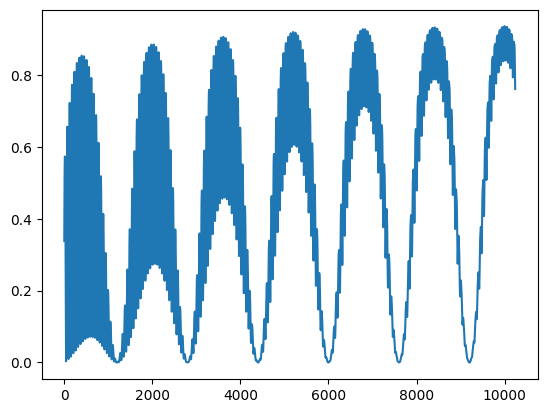

ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred


In [ ]:

root = Tk()
tk = LabelFrame(root, text="Prueba", bg="#808090")

# c = C(440, nombre="Const", tk=tk, show=True)
# c.doShow()
amp = Sine(C(30, show=True), 
           min=C(0), 
           max=C(1, show=True), 
           show=True)

phase=Sine(C(880, show=True), 
           max=C(1, show=True),
           min=C(0, show=True),
           show=True 
           ) 

s = Sine(
    C(1), 
    amp=C(1, show=True),
    phase=phase,
    # nombre="Seno", 
    show=True
    )

s1 = Triangle(
    C(1), 
    amp=deepcopy(amp),
    phase=s,
    # nombre="Seno", 
    show=True
    )

s2 = Sine(
    C(440), 
    amp=deepcopy(amp),
    phase=deepcopy(phase),
    # nombre="Seno", 
    show=True
    )

# freq = Sine(C(4), 
#             max=C(440, show=True), 
#             min=C(220, show=True),
#             show=True) 

# s1 = Rep(freq, XP(valor=freq, exp=C(4)) * C(2) - C(1))
# s.doShow(tk)

freq = Sine(C(5000) / X(avoid0=True), 
            max=C(440, show=True), 
            min=C(220, show=True),
            show=True)

# s1 = Rep(freq, XP(valor=freq, exp=C(4)) * C(2) - C(1), show=True)

tk.pack(side=LEFT)

a = C(1, show=True, nombre="general")
# a.doShow(tk)

# synt = Synt(C(1), s, amp=a, show=True, nombre="Synt")
synt = HarmSynt(C(1), [C(1/12, show=True), C(1*4/12, show=True), C(.5*8/12, show=True)], [s1, s2, deepcopy(s1)], show=True, fmix=tanh, amp=a)
env = EnvInstrumento(.2, .1, .7, .2, show=True)

inst = Instrumento(synt, env) # cutre
inst.doShow(tk)
# root.pack(side=TOP)
# input = Mixer([inst], tanh)
input = inst
# input=Echo(inst, 0.5, 0.1)
root.mainloop()
input = None

showOsc(synt, 10, True)


Uso del sampler y el sampler cíclico

ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred


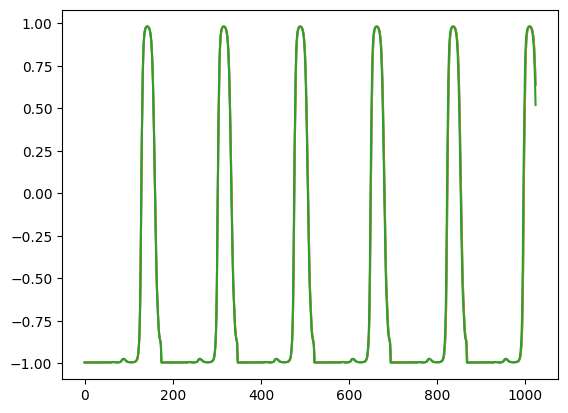

In [ ]:
input = None
a = C(1, show=True, nombre="general")

root = Tk()
tk = LabelFrame(root, text="Prueba", bg="#808090")

freq = Sine(C(5000) / X(avoid0=True), 
            max=C(440, show=True), 
            min=C(220, show=True),
            show=True)

s1 = Rep(freq, XP(valor=freq, exp=C(4)) * C(2) - C(1), show=True)
# sol
synt = HarmSynt(C(3322, show=True, to=5000, step=1), [C(1/12, show=True), C(1*4/12, show=True), C(.5*8/12, show=True)], [s1, deepcopy(s1), deepcopy(s1)], show=True, fmix=tanh, amp=a)
# input = synt
# synt.doShow(tk)
# tk.pack()
# root.mainloop()
# showOsc(synt, CHUNK)

onda = []
for i in range(0, int(209*2)):
    onda = np.concatenate((onda, synt.next()))
# plt.plot(onda[:CHUNK])
synt = HarmSynt(C(3322, show=True, to=5000, step=1), [C(1/12, show=True), C(1*4/12, show=True), C(.5*8/12, show=True)], [s1, deepcopy(s1), deepcopy(s1)], show=True, fmix=tanh, amp=a)
rsamp = RSampler(C(3322), onda, og_freq=C(3322))
samp = Sampler(C(3322), onda, C(3322))
showOsc(rsamp, 1, True)
showOsc(samp, 1, True)
showOsc(synt, 1, True)
input = rsamp


In [ ]:
input = None

# MIAU
    necesario usar python 3.12 o inferior (por librosa)

ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred


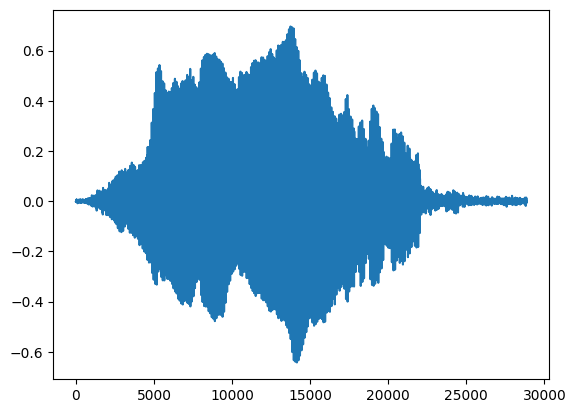

In [ ]:
data, sr = librosa.load("miau.wav", sr=SRATE)
data = data[2000:]
plt.plot(data[:SRATE])
# miau
s = Sampler(C(880), data)
input = s

In [ ]:
s = Sampler(C(880), data, C(3000))
input = s

In [ ]:
# data = Sine(C(440)).next()
s = Sampler(C(440), data, og_freq=C(880), samedur=False)
s2 = Sampler(C(440), data, og_freq=C(880), samedur=True)

# s = Sine(C(1))
# gato en burbuja
# synt = Synt(C(1), s, amp=Sine(C(30, show=True), min=C(0, show=True), max=C(1, show=True), show=True), show=True)

#coro de gatos (suena un poco raro)
# synt = HarmSynt(C(1), [C(1), C(3/2), C(9/8)], [s2])

# gato
synt = Synt(C(1), s, amp=C(1, show=True), show=True)


env = EnvInstrumento(.0, 1, 1, .5, show=True)
inst = Instrumento(synt, env) # cutre
root = Tk()
tk = LabelFrame(root, text="Prueba", bg="#808090")


inst.doShow(tk)
input = inst
tk.pack(side=LEFT)
root.mainloop()
input=None
# inst.noteOn(48)

# plt.plot(np.concatenate((data, data, data, data, data)))
# showOsc(inst, 5, True)


ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred


noteOn 48 (523.2511306011972Hz)
noteOff 48 (523.2511306011972Hz)
noteOn 50 (587.3295358348151Hz)
noteOff 50 (587.3295358348151Hz)
noteOn 52 (659.2551138257398Hz)
noteOff 52 (659.2551138257398Hz)
off
off
off
noteOn 59 (987.7666025122483Hz)
noteOff 59 (987.7666025122483Hz)
off
noteOn 61 (1108.7305239074883Hz)
noteOff 61 (1108.7305239074883Hz)
noteOn 62 (1174.6590716696303Hz)
noteOff 62 (1174.6590716696303Hz)
off
off
noteOn 59 (987.7666025122483Hz)
noteOff 59 (987.7666025122483Hz)
off
noteOn 48 (523.2511306011972Hz)
noteOff 48 (523.2511306011972Hz)
noteOn 50 (587.3295358348151Hz)
noteOff 50 (587.3295358348151Hz)
noteOn 52 (659.2551138257398Hz)
noteOff 52 (659.2551138257398Hz)
off
off
off
noteOn 48 (261.6255653005986Hz)
noteOff 48 (261.6255653005986Hz)
noteOn 48 (261.6255653005986Hz)
noteOff 48 (261.6255653005986Hz)
noteOn 48 (261.6255653005986Hz)
noteOff 48 (261.6255653005986Hz)
noteOn 50 (293.6647679174076Hz)
noteOff 50 (293.6647679174076Hz)
noteOn 50 (293.6647679174076Hz)
noteOff 50 (29

In [ ]:
input = None
def callback(outdata, frames, time, status):    
    if status: print(status)    
    #print(inputs)
    s = np.sum([i.next() for i in inputs],axis=0)
    s = np.float32(s)
    outdata[:] = s.reshape(-1, 1)

# os.system('xset r off')
tk = Tk()

inst0 = Instrumento(Synt(C(1), Sine(C(1)), amp=C(1, show=True)), deepcopy(env))

seq = MidiSequencerTk(tk,[inst, inst0])
#print(seq.seq)
inputs = [inst, inst0]

stream = sd.OutputStream(samplerate=SRATE, channels=1, blocksize=CHUNK, callback=callback)
stream.start()

tk.mainloop()

stream.close()

noteOn 48 (130.8127826502993Hz)
noteOff 48 (130.8127826502993Hz)
noteOn 50 (146.8323839587038Hz)
noteOff 50 (146.8323839587038Hz)
noteOn 52 (164.81377845643496Hz)
noteOff 52 (164.81377845643496Hz)
off
noteOn 52 (164.81377845643496Hz)
noteOff 52 (164.81377845643496Hz)
off
off
noteOn 48 (523.2511306011972Hz)
noteOff 48 (523.2511306011972Hz)
noteOn 48 (523.2511306011972Hz)
noteOff 48 (523.2511306011972Hz)
noteOn 48 (523.2511306011972Hz)
noteOff 48 (523.2511306011972Hz)
noteOn 50 (587.3295358348151Hz)
noteOff 50 (587.3295358348151Hz)
noteOn 52 (659.2551138257398Hz)
off
off
noteOff 52 (659.2551138257398Hz)
off
noteOn 48 (523.2511306011972Hz)
noteOff 48 (523.2511306011972Hz)
off
noteOn 59 (987.7666025122483Hz)
noteOff 59 (987.7666025122483Hz)
off


# 2. SAMPLER CON ATK Y SUSTAIN

ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred


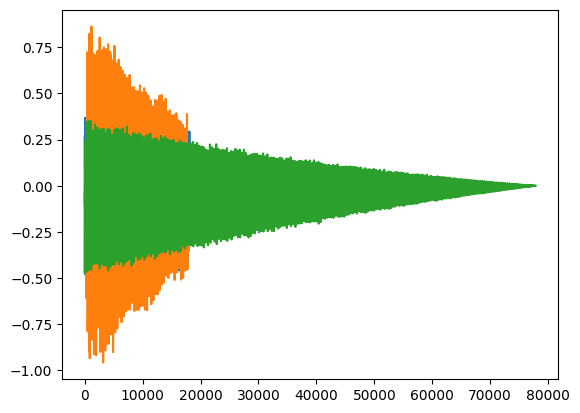

In [ ]:
data_atk, _ = librosa.load("piano_atk.wav", sr=SRATE)
data_rel, _ = librosa.load("piano_rel.wav", sr=SRATE)
data_sus, _ = librosa.load("piano_sus.wav", sr=SRATE)
plt.plot(data_sus)
plt.plot(data_atk)
plt.plot(data_rel)

In [ ]:
input = None
def callback(outdata, frames, time, status):    
    if status: print(status)    
    #print(inputs)
    s = np.sum([i.next() for i in inputs],axis=0)
    s = np.float32(s)
    outdata[:] = s.reshape(-1, 1)

os.system('xset r off')
tk = Tk()

# s_atk = Sampler(C(440), data_atk, og_freq=C(880), samedur=False)
# s_sus = Sampler(C(440), data_sus, og_freq=C(880), samedur=False)
# s_rel = Sampler(C(440), data_rel, og_freq=C(880), samedur=False)

samplefreq = 440
s = InstSampler(C(440), data_atk, C(samplefreq), data_sus, C(samplefreq), data_rel, C(samplefreq))

# gato
synt = Synt(C(1), s, amp=C(1, show=True), show=True)

env = EnvInstrumento(.0, 1, 1, .5, show=True)
inst = Instrumento(synt, env) # cutre

seq = MidiSequencerTk(tk,[inst])
#print(seq.seq)
inputs = [inst]

stream = sd.OutputStream(samplerate=SRATE, channels=1, blocksize=CHUNK, callback=callback)
stream.start()

tk.mainloop()

stream.close()

noteOn 48 (523.2511306011972Hz)
noteOff 48 (523.2511306011972Hz)
noteOn 50 (587.3295358348151Hz)
noteOff 50 (587.3295358348151Hz)
noteOn 52 (659.2551138257398Hz)
noteOff 52 (659.2551138257398Hz)
off
noteOn 53 (698.4564628660078Hz)
noteOff 53 (698.4564628660078Hz)
off
noteOn 55 (783.9908719634985Hz)
off
noteOff 55 (783.9908719634985Hz)
noteOn 59 (987.7666025122483Hz)
off
noteOff 59 (987.7666025122483Hz)
off
off
noteOn 48 (523.2511306011972Hz)
noteOff 48 (523.2511306011972Hz)
noteOn 50 (587.3295358348151Hz)
noteOff 50 (587.3295358348151Hz)
noteOn 52 (659.2551138257398Hz)
noteOff 52 (659.2551138257398Hz)
off
noteOn 53 (698.4564628660078Hz)
noteOff 53 (698.4564628660078Hz)
off
noteOn 55 (783.9908719634985Hz)
off
noteOff 55 (783.9908719634985Hz)
noteOn 57 (880.0Hz)
off
noteOff 57 (880.0Hz)
noteOn 59 (987.7666025122483Hz)
noteOff 59 (987.7666025122483Hz)
off
off
off
noteOn 48 (523.2511306011972Hz)
noteOff 48 (523.2511306011972Hz)
noteOn 50 (587.3295358348151Hz)
noteOff 50 (587.3295358348151H

In [ ]:

# freq = C(440)

freq = Sine(C(20000) / X(avoid0=True), 
            max=C(440, show=True), 
            min=C(220, show=True),
            show=True)


s1 = Rep(freq, XP(valor=freq, exp=C(4)) * C(2) - C(1))
s2 = Rep(freq, XP(valor=freq, exp=C(1/4)) * C(3) - C(2))
# s2 = Rep(C(440), XP(valor=C(440), pow=C(2)) * C(2) - C(1), phase=Sine(C(440)))
s3 = Sawtooth(freq, phase=C(np.pi/2))
showOsc(s1, 1, True)
showOsc(s2, 1, True)
showOsc(s3, 1, True)
input = s1

In [ ]:
freq = Sine(C(5000) / X(avoid0=True), 
            max=C(440, show=True), 
            min=C(220, show=True),
            show=True)


s1 = Rep(freq, XP(valor=freq, exp=C(4)) * C(2) - C(1))
s = Mixer([s1], tanh)
input = s
showOsc(s, 1, chunks=True)

# FILTROS

In [ ]:
# %%writefile synt/filter.py

from synt.function import *
from synt.const import *
from tkinter import *
import numpy as np

from synt.osc import *

# TODO ver si satura
class FilterIIR(Function):
    ''' recibe una funcion (generador de ondas) y devuelve su onda filtrada'''
    def __init__(self,signal:Function,alpha:Function, nombre='IIR',show=True):
        super().__init__(show, nombre)
        self.signal = signal
        self.mem = 0
        
        self.alpha = alpha
        if isinstance(alpha, Const):
            self.alpha_mem = alpha.next(np.arange(0, CHUNK))
        else:
            self.alpha_mem = 0
        # self.step = step 
        # por defecto inactivo
        self.act = False

    def fun(self, tiempo):
        data = self.signal.next(tiempo)
        
        if isinstance(self.alpha, Const):
            _alpha = np.full(CHUNK, self.alpha.next(tiempo))
        else:
            _alpha = self.alpha.next(tiempo)
        
        if self.act:
            data[0] = self.mem + self.alpha_mem * (data[0]-self.mem)
            for i in range(1,CHUNK):
                data[i] = data[i-1] + _alpha[i] * (data[i]-data[i-1])
            self.mem = data[CHUNK-1]
            
        self.mem = data[-1] # actualizamos memo con ultima muestra
        self.alpha_mem = float(_alpha[-1])
        
        return data

    def activate(self):
        self.act = True

    def deactivate(self):
        self.act = False    

    def isActive(self):
        return self.act

    def doShow(self, tk, bg="#808090", side=TOP):
        _tk = super().doShow(tk, bg, side=TOP)
        # TODO hacer un boton para activar/desactivar
        self.alpha.addNombre('alpha')
        self.alpha.doShow(_tk, bg, side)
        
        return _tk
    # no hace falta teniendo el do show
    # def upAlpha(self):
        # self.alpha = min(2.0,max(0.1,self.alpha+self.step))

    # def downAlpha(self):
        # self.alpha = min(2.0,max(0.1,self.alpha-self.step))


Overwriting synt/filter.py


In [ ]:
loop, _ = librosa.load("loop.wav", sr=SRATE)
rsamp = RSampler(C(440, show=True), loop, C(400), C(1))
alpha =  C(1, show=True, step=0.01, fr=0, to=2)
# alpha = Sine(freq=C(0.5, show=True), max=C(1, to=2, show=True), min=C(.5, to=2, show=True), show=True)

filt = FilterIIR(rsamp, alpha)
f = 1
for i in range(0, f):
    filt = FilterIIR(filt, alpha)
# synt = Synt(C(1), filt, C(1, show=True))

tk = Tk()
input = filt
filt.activate()
filt.doShow(tk)
tk.mainloop()
# showOsc(filt, .2)
# showOsc(rsamp, .2)
# TODO arreglar perdida en la amplitud y en la fase

ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred


intentando hacer un filtro de bajos

In [ ]:
%%writefile synt/filter.py

from copy import deepcopy
from synt.function import *
from synt.const import *
from tkinter import *
import numpy as np

from synt.osc import *

# TODO ver si satura
class FilterIIR(Function):
    ''' recibe una funcion (generador de ondas) y devuelve su onda filtrada'''
    def __init__(self,signal:Function,alpha:Function, act=False, nombre='IIR',show=True):
        super().__init__(show, nombre)
        self.signal = signal
        self.mem = 0
        
        self.alpha = alpha
        if isinstance(alpha, Const):
            self.alpha_mem = alpha.next(np.arange(0, CHUNK))
        else:
            self.alpha_mem = 0
        # self.step = step 
        # por defecto inactivo
        self.act = act

    def fun(self, tiempo):
        data = self.signal.next(tiempo)
        
        if isinstance(self.alpha, Const):
            _alpha = np.full(CHUNK, self.alpha.next(tiempo))
        else:
            _alpha = self.alpha.next(tiempo)
        
        if self.act:
            data[0] = self.mem + self.alpha_mem * (data[0]-self.mem)
            for i in range(1,CHUNK):
                data[i] = data[i-1] + _alpha[i] * (data[i]-data[i-1])
            self.mem = data[CHUNK-1]
            
        self.mem = data[-1] # actualizamos memo con ultima muestra
        self.alpha_mem = float(_alpha[-1])
        
        return data

    def activate(self):
        self.act = True

    def deactivate(self):
        self.act = False    

    def isActive(self):
        return self.act

    def doShow(self, tk, bg="#808090", side=TOP):
        _tk = super().doShow(tk, bg, side=TOP)
        # TODO hacer un boton para activar/desactivar
        self.alpha.addNombre('alpha')
        self.alpha.doShow(_tk, bg, side)
        
        return _tk
    # no hace falta teniendo el do show
    # def upAlpha(self):
        # self.alpha = min(2.0,max(0.1,self.alpha+self.step))

    # def downAlpha(self):
        # self.alpha = min(2.0,max(0.1,self.alpha-self.step))

class LPFilter(FilterIIR):
    def __init__(self,signal:Function,alpha:Function, act=False ,nombre='IIR',show=True):
        super().__init__(signal,alpha, nombre='LP',show=True)
        # _IIR1 = FilterIIR(Reverse(deepcopy(self.signal)), self.alpha, self.act)
        self.lp_0 = FilterIIR(deepcopy(self.signal), self.alpha, self.act)
        self.lp = FilterIIR(Reverse(self.lp_0), self.alpha, self.act)
        
    def fun(self, tiempo):
        if self.act:
            return self.lp_0.next(tiempo)
        else: 
            return self.signal.next(tiempo)
        # aplicamos dos veces para corregir el desplazamiento de fase
        
    def activate(self):
        self.act = True
        self.lp_0.activate()
        self.lp.activate()

    def deactivate(self):
        self.act = False  
        self.lp_0.deactivate()
        self.lp.deactivate()

class HPFilter(FilterIIR):
    def __init__(self,signal:Function,alpha:Function, nombre='IIR',show=True):
        super().__init__(signal,alpha, nombre='LP',show=True)
        # self.alpha = -alpha
        self.lp = LPFilter(signal,alpha, self.act)
    
    def fun(self, tiempo):
        
        if self.act:
            _lp = self.lp.next(tiempo)
            return self.signal.next(tiempo) - _lp
        else: 
            return self.signal.next(tiempo)
        
    def activate(self):
        self.act = True
        self.lp.activate()

    def deactivate(self):
        self.act = False  
        self.lp.deactivate()
        
    



Overwriting synt/filter.py


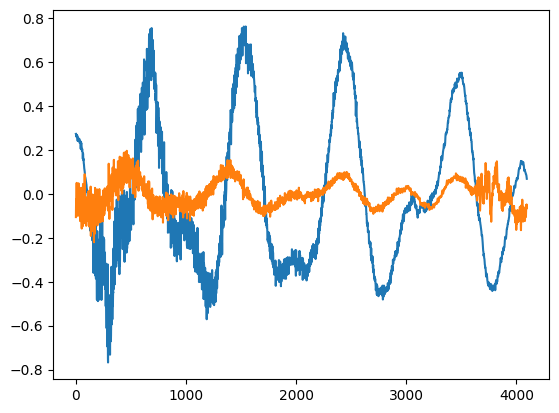

In [6]:
loop, _ = librosa.load("loop.wav", sr=SRATE)
rsamp = RSampler(C(440, show=True), loop, C(400), C(1))
alpha =  C(.5, show=True, step=0.01, fr=0, to=2)
# alpha = Sine(freq=C(0.5, show=True), max=C(1, to=2, show=True), min=C(.5, to=2, show=True), show=True)

filt = HPFilter(rsamp, alpha)
# synt = Synt(C(1), filt, C(1, show=True))

tk = Tk()
input = filt
filt.activate()
filt.doShow(tk)
tk.mainloop()
showOsc(rsamp, .1)
showOsc(filt, .1)
# TODO arreglar perdida en la amplitud y en la fase